# Importing Libraries

Created the notebook with the some edits to the notebook of @saidrasidin. 

In [ ]:
pip freeze

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms as T
from torchvision.utils import make_grid
import torch.nn.functional as F
from torch.autograd import Variable

import numbers
from PIL import Image, ImageOps
import math
import zipfile
import matplotlib.image as mpimg
from collections import defaultdict
import time
from tqdm.notebook import tqdm
import albumentations as A #great data augmentation lib
import cv2

#%matplotlib.pyplot inline

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

In [ ]:
#!pip install fastai
from fastai.vision.models import resnet34, unet


In [3]:
#! pip install torchsummary
#from torchsummary import summary
!pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

     |████████████████████████████████| 66 kB 624 kB/s eta 0:00:01
     |████████████████████████████████| 244 kB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 2.0 MB/s eta 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=8153c2b7ea0436d7f3aeb0f8e49c947f8f2ee26c41f0f9eef74585204642e361
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=12e6af49dca9b6e4c60af9c03cba2587e222a3ee06eb094e00ce4d9ce0cb16e9
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [ ]:
!pip install fastbook
fastbook.setup_book()

In [ ]:
from fastbook import *
from fastai.vision.widgets import *

# Input Data

In [4]:
with zipfile.ZipFile("/kaggle/input/tgs-salt-identification-challenge/train.zip") as z:
    z.extractall("./train/")
with zipfile.ZipFile("/kaggle/input/tgs-salt-identification-challenge/test.zip") as z:
    z.extractall("./test/")
# ! unzip "/kaggle/input/tgs-salt-identification-challenge/train.zip" -d './train/'
# ! unzip "/kaggle/input/tgs-salt-identification-challenge/test.zip" -d './test/'
print('unzip finished')

unzip finished


In [5]:
TRAIN_CSV = '/kaggle/input/tgs-salt-identification-challenge/train.csv'
DEPTH_CSV = '/kaggle/input/tgs-salt-identification-challenge/depths.csv'

TRAIN_IMAGE_DIR = '/kaggle/working/train/images/'
TRAIN_MASK_DIR = '/kaggle/working/train/masks/'

TEST_IMAGE_DIR = '/kaggle/working/test/images/'

In [6]:
df_train = pd.read_csv(TRAIN_CSV)
df_depth = pd.read_csv(DEPTH_CSV)

df = pd.merge(df_depth, df_train)
df['salt'] = df['rle_mask'].notnull().replace([False, True], [0,1]) 
#0 = no_salt #1 = salt

df.head()

,id,z,rle_mask,salt
0,4ac19fb269,306,5757 1 5851 8 5936 24 6034 27 6134 28 6224 39 ...,1
1,1825fadf99,157,NaN,0
2,f59821d067,305,36 66 137 66 239 65 340 65 442 64 543 64 644 6...,1
3,5b435fad9d,503,7474 1 7574 2 7674 3 7774 4 7874 5 7974 6 8074...,1
4,e340e7bfca,783,NaN,0


In [ ]:
df.info()

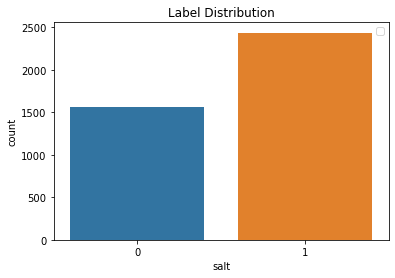

In [7]:
no_salt = df[df['rle_mask'].isnull()]
salt = df[df['rle_mask'].notnull()]

# dist = (len(no_salt), len(salt))
# plt.bar([0,1], dist, color=['g', 'b'])
sns.countplot(df['salt'])
#plt.xticks(ticks= [0,1], labels=['no salt', 'salt'])
plt.title('Label Distribution')
plt.legend()

#we see the data is imbalanced.

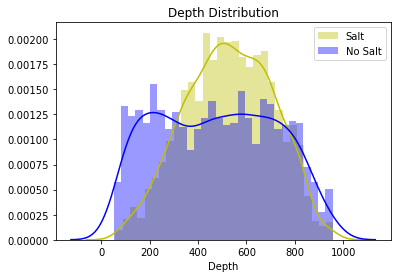

In [8]:
#need to add new plots here--------------------------------------------------------

sns.distplot(salt['z'], label='Salt', bins=30, color='y')
sns.distplot(no_salt['z'], label='No Salt', bins=30, color='b')
plt.title('Depth Distribution')
plt.xlabel('Depth'); plt.legend()
plt.show()

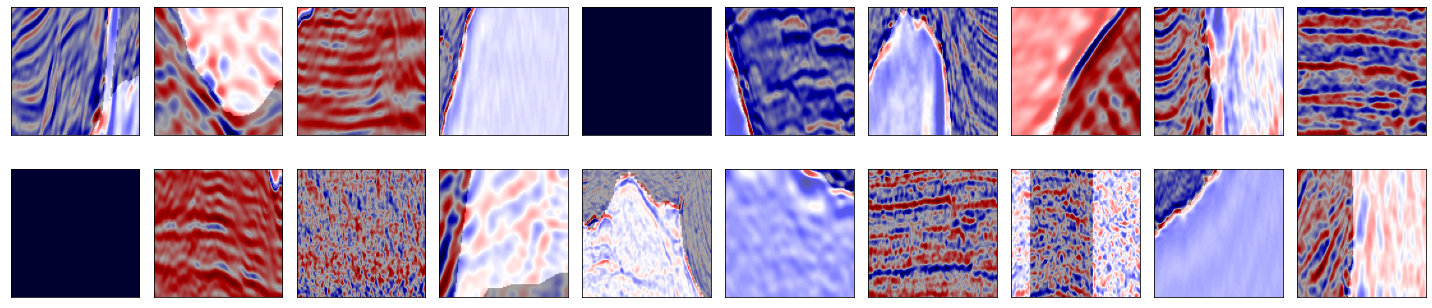

In [9]:
#check sample image
fig = plt.figure(figsize=(20, 5))

rand_idx = np.random.randint(0, 4000, 20) #generate random indexes

for i, file in enumerate(rand_idx):
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks = [])
    figs = df['id'][file]
    img = mpimg.imread(f'/kaggle/working/train/images/{figs}.png')
    mask = mpimg.imread(f'/kaggle/working/train/masks/{figs}.png')
    ax.imshow(img[:,:,0], cmap='seismic')
    ax.imshow(mask, alpha=0.35, cmap='gray')
    
plt.tight_layout()
plt.show()

## Data Handling

In [10]:
class Seismic(Dataset):
    def __init__(self, img_root, mask_root, X, transform=None):
        self.img_dir = img_root
        self.mask_dir = mask_root
        self.X = X
        self.transform = transform
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        
        img_id = self.X[idx]
        
        img_path = self.img_dir + str(img_id) + ".png"
        mask_path = self.mask_dir + str(img_id) + ".png"
        
#         img = Image.open(img_path).resize((128, 128))
#         mask = Image.open(mask_path).resize((128, 128))
        img = cv2.imread(img_path)
        img = cv2.resize(img, (128,128))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(mask_path)
        mask = cv2.resize(mask, (128,128))
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask) #transform image and mask
            
            img = Image.fromarray(aug['image'])
            mask = Image.fromarray(aug['mask']).convert('L') #convert to 1channel
            
            t = T.ToTensor()
            img = t(img)
            mask = t(mask)
        
        if self.transform is None:
            img = Image.fromarray(img)
            mask = Image.fromarray(mask).convert('L')
            
            t = T.ToTensor()
            img = t(img)
            mask = t(mask)
        return img, mask

## Augmentation

## Split Data Train/Val/Test

In [11]:
X_trainval, X_test, y_trainval, y_test = train_test_split(df['id'].values, df['salt'].values,
                                                          stratify=df['salt'].values, 
                                                          test_size=0.05, random_state=97)

X_train, X_val = train_test_split(X_trainval, stratify=y_trainval, 
                                  test_size=0.1, random_state=97)

len(X_train), len(X_val), len(X_test)

(3420, 380, 200)

In [12]:
transform = A.Compose([A.HorizontalFlip(), 
                       A.VerticalFlip(),
                       A.RandomRotate90(), 
                       A.OpticalDistortion(),
                       A.Transpose()])

train_set = Seismic(TRAIN_IMAGE_DIR, TRAIN_MASK_DIR, X_train, transform=transform)
val_set = Seismic(TRAIN_IMAGE_DIR, TRAIN_MASK_DIR, X_val, transform)
test_set = Seismic(TRAIN_IMAGE_DIR, TRAIN_MASK_DIR, X_test, transform=None)

In [ ]:
show_bunch(train_set)

Image_size:  torch.Size([3, 128, 128])
Mask_size:  torch.Size([1, 128, 128])
Max Pixel Image Val: tensor(0.9059)
Max Pixel mask Val: tensor(1.)


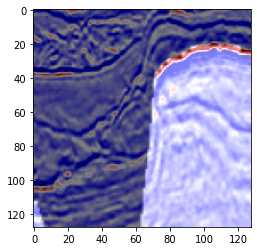

In [13]:
img, mask = test_set[21]
print("Image_size: ", img.size())
print("Mask_size: ", mask.size())
print('Max Pixel Image Val:', img.max())
print('Max Pixel mask Val:', mask.max())
plt.imshow(img[0], cmap='seismic')
plt.imshow(mask[0], alpha=0.5, cmap='gray');

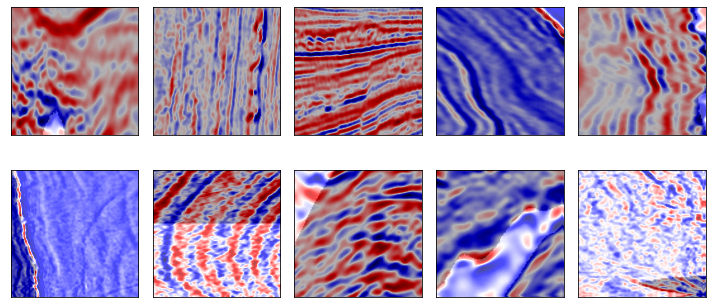

In [14]:
#check dataset with augmentation
fig = plt.figure(figsize=(10, 5))

rand_idx = np.random.randint(0, 3420, 10) #generate random indexes

for i, file in enumerate(rand_idx):
    image, mask = train_set[file]
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks = [])
    ax.imshow(image[0], cmap='seismic')
    ax.imshow(mask[0], cmap='gray', alpha=0.3)

plt.tight_layout(); plt.show()

## Dataloader

In [15]:
from fastai import *
ImageDataBunch.from_name_re(train_set)

NameError: name 'ImageDataBunch' is not defined

In [18]:
#dataloader
batch_size = 32
#from fastai.vision import *

#from fastai.data.load import DataLoader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

In [19]:
def show_batch(dl):
    for images, mask in dl:
        fig, ax = plt.subplots(figsize=(20, 20))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0), cmap='seismic')
        ax.imshow(make_grid(mask, nrow=16).permute(1, 2, 0), alpha=0.5)
        break

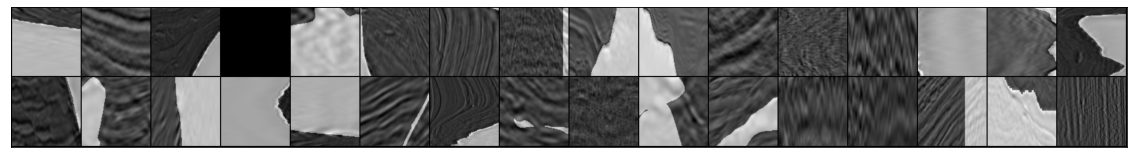

In [20]:
show_batch(train_loader)

In [ ]:
train_loader

In [ ]:
show_batch(val_loader)

# Model

## Resnet34 (The Easy Way)

In [21]:
#m = resnet34()
#m = nn.Sequential(*list(m.children())[:-2])
#res34_fai = unet.DynamicUnet(m, 3, (128,128), norm_type=None)
#x = torch.randn(2, 3, 128, 128)
#y = tst(x)

#res34_fai.to(device)

#res34_fai.train()
#res34_fai


model_res34 = smp.Unet('resnet34', classes=1, activation='sigmoid')

model_res34.to(device)

model_res34.train()
model_res34

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

# Training
## Help Functions
### Costum Loss Functions

In [23]:
##loval loss :https://github.com/bermanmaxim/LovaszSoftmax/blob/master/pytorch/lovasz_losses.py

def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels

def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss

def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    return loss

#PyTorch
class LovaszHingeLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(LovaszHingeLoss, self).__init__()

    def forward(self, inputs, targets):
        #inputs = F.sigmoid(inputs)    
        Lovasz = lovasz_hinge(inputs, targets, per_image=False)                       
        return Lovasz
    
##Dice Loss
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-5):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        #inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

### Custom Metrices

In [24]:
def accuracy(output, mask):
    ps = torch.exp(output)
    _, top_class = ps.topk(1, dim=1)
    correct = top_class == mask.view(*top_class.shape)
    score = torch.mean(correct.type(torch.FloatTensor)).item()
    return score


def IoU_score(inputs, targets, smooth=1e-5):
    #flatten label and prediction tensors
    inputs = inputs.view(-1)
    targets = targets.view(-1)

    #intersection is equivalent to True Positive count
    #union is the mutually inclusive area of all labels & predictions 
    intersection = (inputs * targets).sum()
    total = (inputs + targets).sum()
    union = total - intersection 

    IoU = (intersection + smooth)/(union + smooth)
    
    return IoU

def Dice_score(inputs, targets, smooth=1e-5):
    inputs = inputs.view(-1)
    targets = targets.view(-1)

    intersection = (inputs * targets).sum()                            
    dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
    
    return dice

In [25]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_dice = [];
    train_iou = []; train_dice = [];
    lrs = []
    
    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        dice_score = 0
        #training loop
        for image, mask in train_loader:
            #training phase
            model.train()
            image = image.to(device); mask = mask.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            
            #score
            iou_score += IoU_score(output, mask).item()
            dice_score += Dice_score(output, mask).item()
            
            #backward
            loss.backward() 
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
        
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            total_train = 0
            correct_train = 0
            val_iou_score = 0
            val_dice_score = 0
            #validation loop
            with torch.no_grad():
                for image, mask in val_loader:
                    image = image.to(device); mask = mask.to(device);
                    output = model(image)
                    #score
                    val_iou_score +=  IoU_score(output, mask).item()
                    val_dice_score += Dice_score(output, mask).item()
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            #dice
            val_dice.append(val_dice_score/len(val_loader))
            train_dice.append(dice_score/len(train_loader))
        
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train IoU/Dice:{:.3f}/{:.3f}..".format((iou_score/len(train_loader)),(dice_score/len(train_loader))),
                  "Val IoU/Dice: {:.3f}/{:.3f}..".format((val_iou_score/len(val_loader)),(val_dice_score/len(val_loader))), 
                  "Time: {:.2f}s".format((time.time()-since)))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_dice':train_dice, 'val_dice': val_dice,
               'train_iou' :train_iou, 'val_iou':val_iou, 
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

## Training (Learning Time) 

## Resnet34

In [26]:
#model resnet34
#model_res34 = smp.Unet('resnet34', classes=1, activation='sigmoid')
#model_res34.to(device)
#model_res34.train()

max_lr = 1e-3 #1e-4
epoch = 20
weight_decay = 1e-4

criterion = nn.BCELoss()
optimizer34 = torch.optim.AdamW(model_res34.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer34, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history34 = fit(epoch, model_res34, train_loader, val_loader, criterion, optimizer34, sched)

Epoch:1/20.. Train Loss: 0.472.. Val Loss: 0.334.. Train IoU/Dice:0.265/0.414.. Val IoU/Dice: 0.406/0.573.. Time: 16.67s
Epoch:2/20.. Train Loss: 0.312.. Val Loss: 0.291.. Train IoU/Dice:0.444/0.612.. Val IoU/Dice: 0.502/0.666.. Time: 16.48s
Epoch:3/20.. Train Loss: 0.277.. Val Loss: 0.530.. Train IoU/Dice:0.499/0.663.. Val IoU/Dice: 0.362/0.525.. Time: 16.03s
Epoch:4/20.. Train Loss: 0.291.. Val Loss: 0.205.. Train IoU/Dice:0.487/0.651.. Val IoU/Dice: 0.639/0.778.. Time: 16.29s
Epoch:5/20.. Train Loss: 0.269.. Val Loss: 0.271.. Train IoU/Dice:0.519/0.681.. Val IoU/Dice: 0.537/0.696.. Time: 16.01s
Epoch:6/20.. Train Loss: 0.253.. Val Loss: 0.250.. Train IoU/Dice:0.544/0.702.. Val IoU/Dice: 0.576/0.728.. Time: 16.30s
Epoch:7/20.. Train Loss: 0.240.. Val Loss: 0.491.. Train IoU/Dice:0.557/0.713.. Val IoU/Dice: 0.354/0.519.. Time: 16.08s
Epoch:8/20.. Train Loss: 0.220.. Val Loss: 0.262.. Train IoU/Dice:0.586/0.736.. Val IoU/Dice: 0.585/0.737.. Time: 16.37s
Epoch:9/20.. Train Loss: 0.217..

In [27]:
max_lr = 1e-5 #1e-4
epoch = 20

criterion_dice34 = DiceLoss()
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer34, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history34_dice = fit(epoch, model_res34, train_loader, val_loader, 
                criterion_dice34, optimizer34, sched)

Epoch:1/20.. Train Loss: 0.150.. Val Loss: 0.147.. Train IoU/Dice:0.742/0.850.. Val IoU/Dice: 0.748/0.853.. Time: 16.30s
Epoch:2/20.. Train Loss: 0.146.. Val Loss: 0.144.. Train IoU/Dice:0.749/0.854.. Val IoU/Dice: 0.751/0.856.. Time: 16.27s
Epoch:3/20.. Train Loss: 0.141.. Val Loss: 0.128.. Train IoU/Dice:0.757/0.859.. Val IoU/Dice: 0.775/0.872.. Time: 16.50s
Epoch:4/20.. Train Loss: 0.132.. Val Loss: 0.134.. Train IoU/Dice:0.769/0.868.. Val IoU/Dice: 0.769/0.866.. Time: 16.36s
Epoch:5/20.. Train Loss: 0.128.. Val Loss: 0.124.. Train IoU/Dice:0.776/0.872.. Val IoU/Dice: 0.781/0.876.. Time: 16.22s
Epoch:6/20.. Train Loss: 0.114.. Val Loss: 0.114.. Train IoU/Dice:0.798/0.886.. Val IoU/Dice: 0.797/0.886.. Time: 16.35s
Epoch:7/20.. Train Loss: 0.116.. Val Loss: 0.116.. Train IoU/Dice:0.796/0.884.. Val IoU/Dice: 0.796/0.884.. Time: 16.19s
Epoch:8/20.. Train Loss: 0.111.. Val Loss: 0.114.. Train IoU/Dice:0.804/0.889.. Val IoU/Dice: 0.799/0.886.. Time: 16.32s
Epoch:9/20.. Train Loss: 0.113..

In [28]:
def combine_history(history18, history18_dice):
    t_loss = history18['train_loss'] + history18_dice['train_loss']
    v_loss = history18['val_loss'] + history18_dice['val_loss']
    t_dice = history18['train_dice'] + history18_dice['train_dice']
    v_dice = history18['val_dice'] + history18_dice['val_dice']
    t_iou = history18['train_iou'] + history18_dice['train_iou']
    v_iou = history18['val_iou'] + history18_dice['val_iou']
    lr = history18['lrs'] + history18_dice['lrs']
    comb = {'train_loss':t_loss, 'val_loss':v_loss, 'train_dice':t_dice,
            'val_dice':v_dice, 'train_iou':t_iou, 'val_iou':v_iou, 'lrs':lr}
    return comb

In [29]:
history_resnet34 = combine_history(history34, history34_dice)

In [30]:
torch.save(model_res34.state_dict(), 'salt_resnet34.pth')
torch.save(model_res34,'salt_resnet34.h5')

In [31]:
def plot_loss(x, history):
    plt.plot(x, history['val_loss'], label='val', marker='o')
    plt.plot(x, history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(x, history):
    plt.plot(x, history['train_dice'], label='train_dice', marker='x')
    plt.plot(x, history['val_dice'], label='val_dice', marker='x')
    plt.plot(x, history['train_iou'], label='train_iou', marker='*')
    plt.plot(x, history['val_iou'], label='val_iou',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('score')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

In [32]:
print('RESNET18')
plot_loss(np.arange(1,41), history_resnet18)
plot_score(np.arange(1,41), history_resnet18)

RESNET18


NameError: name 'history_resnet18' is not defined

RESNET34


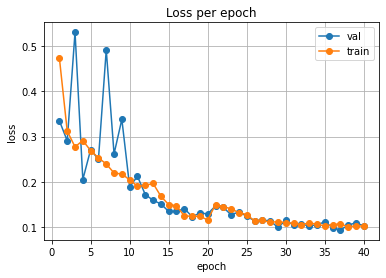

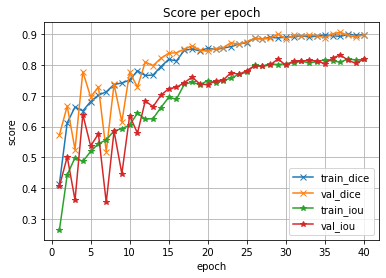

In [33]:
print('RESNET34')
plot_loss(np.arange(1,41), history_resnet34)
plot_score(np.arange(1,41), history_resnet34)

# Inference

In [34]:
def predict_image(model, image, mask, threshold):
    model.eval()
    with torch.no_grad():
        model.to(device)
        image = image.to(device)
        mask = mask.to(device)
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        predict = model(image) > threshold
        score = IoU_score(predict, mask)
        predict = predict.squeeze(0).squeeze(0)
    return predict.cpu(), score.item()

In [35]:
#load model state_dict()
unet_resnet18 = Unet_resnet18(n_classes=1)
unet_resnet18.load_state_dict(torch.load('model_resnet18.pth'))

unet_resnet34 = smp.Unet('resnet34', classes=1, activation='sigmoid')
unet_resnet34.load_state_dict(torch.load('unet_resnet34.pth'))

NameError: name 'Unet_resnet18' is not defined

## Finding Best Threshold

In [36]:
thre = np.linspace(0.4, 0.9, 15)
IoU_mean = []
for thres in thre:
    IoU = 0
    for image, mask in val_set:
        _, score = predict_image(unet_resnet18, image, mask, thres)
        IoU += score
    IoU_mean.append(IoU/len(val_set))

iou_score = pd.DataFrame({"Threshold": thre, "IoU_score": IoU_mean})
iou_score

NameError: name 'unet_resnet18' is not defined

ValueError: x and y must have same first dimension, but have shapes (15,) and (0,)

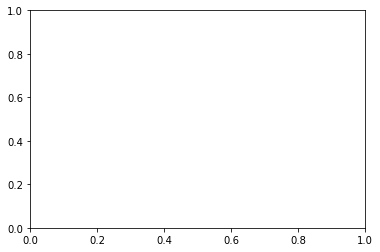

In [37]:
plt.plot(thre, IoU_mean)
plt.plot(thre[np.argmax(IoU_mean)], np.max(IoU_mean), marker='x',
        label='Best Threshold {:.3f}'.format(thre[np.argmax(IoU_mean)]))
plt.grid(); plt.ylabel('IoU Score'); plt.xlabel('Threshold');
plt.title('Best Threshold Finder')
plt.legend()
plt.show()

## Evaluation Using Test Set

In [38]:
score_all = []
for image, mask in test_set:
    _, score = predict_image(unet_resnet18, image, mask, threshold=0.5) #threshold can be different in datasets
    score_all.append(score)
print('IoU score over all test set Resnet18: ',np.mean(score_all))

NameError: name 'unet_resnet18' is not defined

In [39]:
score_all = []
for image, mask in test_set:
    _, score = predict_image(unet_resnet34, image, mask, threshold=0.5) #threshold can be different in datasets
    score_all.append(score)
print('IoU score over all test set Resnet34: ',np.mean(score_all))

NameError: name 'unet_resnet34' is not defined

In [40]:
#test single image
def plot_predict_image(idx):
    image, mask = test_set[idx]
    mask_pre, score = predict_image(unet_resnet34, image, mask, threshold=0.5)

    #plot
    fig = plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(image[0], cmap='seismic')
    plt.contour(mask[0], cmap='Greens')
    plt.title('Seismic'); plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.imshow(mask_pre)
    plt.title('Predict Mask | score: {:.3f}'.format(score))
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.imshow(mask[0])
    plt.title('Ground truth')
    plt.axis('off');
    
    plt.subplot(1, 4, 4)
    plt.imshow(mask_pre, cmap='Greens')
    plt.imshow(mask[0], alpha=0.5)
    plt.title('Overlay Predict and Ground truth')
    plt.axis('off');

In [41]:
a = [159, 173, 53, 94]
for i in a:
    plot_predict_image(i)

NameError: name 'unet_resnet34' is not defined

In [ ]:
! pip install jovian
import jovian
jovian.commit(project= 'salt-segmentation', privacy='private')